Library 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import missingno as msno
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn

import warnings
warnings.filterwarnings('ignore')

# Import data

Importer les donnee avec géolocolisation

In [5]:
# les columns a supprimer
col_include = ['date_mutation', 'nature_mutation', 'valeur_fonciere',
               'adresse_numero',  'code_postal', 'code_commune', 'nom_commune',
               'code_departement', 'nombre_lots', 'code_type_local', 'type_local', 'surface_reelle_bati',
               'nombre_pieces_principales','surface_terrain']
# transformer la columne en datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
data_types = {'code_postal':'string',
              'adresse_numero': 'Int64',
              'nombre_lots':'Int16',
              'surface_reelle_bati': 'Float32',
              'nombre_pieces_principales': 'Int8',
              'surface_terrain':'Float32',
              'code_commune':'object'}
# dtype code postal string
valeur_fonciere_geo_2020 = pd.read_csv('datasets/full2020.csv', sep=",", 
                                   parse_dates=['date_mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=col_include)
valeur_fonciere_geo_2019 = pd.read_csv('datasets/full2019.csv', sep=",", 
                                   parse_dates=['date_mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=col_include)
valeur_fonciere_geo_2018 = pd.read_csv('datasets/full2018.csv', sep=",", 
                                   parse_dates=['date_mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=col_include)
valeur_fonciere_geo_2017 = pd.read_csv('datasets/full2017.csv', sep=",", 
                                   parse_dates=['date_mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=col_include)
valeur_fonciere_geo_2016 = pd.read_csv('datasets/full2016.csv', sep=",", 
                                   parse_dates=['date_mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=col_include)
valeur_fonciere_geo_2015 = pd.read_csv('datasets/full2015.csv', sep=",", 
                                   parse_dates=['date_mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=col_include)

In [7]:
frames_geo = [valeur_fonciere_geo_2020, valeur_fonciere_geo_2019, valeur_fonciere_geo_2018, 
              valeur_fonciere_geo_2017, valeur_fonciere_geo_2016, valeur_fonciere_geo_2015]
df_geo_foncier = pd.concat(frames_geo)

In [8]:
df_geo_foncier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16359982 entries, 0 to 2750304
Data columns (total 14 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   date_mutation              datetime64[ns]
 1   nature_mutation            object        
 2   valeur_fonciere            float64       
 3   adresse_numero             Int64         
 4   code_postal                string        
 5   code_commune               object        
 6   nom_commune                object        
 7   code_departement           object        
 8   nombre_lots                Int16         
 9   code_type_local            float64       
 10  type_local                 object        
 11  surface_reelle_bati        Float32       
 12  nombre_pieces_principales  Int8          
 13  surface_terrain            Float32       
dtypes: Float32(2), Int16(1), Int64(1), Int8(1), datetime64[ns](1), float64(2), object(5), string(1)
memory usage: 1.6+ GB


Recherche des doublons

In [9]:
# Drop duplicates
initial_length = len(df_geo_foncier)
df_geo_foncier.drop_duplicates(inplace=True)
print("Suppression des doublons: {}".format(initial_length-len(df_geo_foncier)))

Suppression des doublons: 1639201


supprimer les transactions repetees

In [10]:
print('origine',len(df_geo_foncier.index))
df_geo_foncier = df_geo_foncier.groupby(['date_mutation','valeur_fonciere']).filter(lambda x: len(x) == 1)
print('apres',len(df_geo_foncier.index))

origine 14720781
apres 1009960


Construire la dataframe de maison et appartement

In [11]:
# df_MA = maison + appartment
df_geo_foncier.rename(columns={'code_commune':'Code INSEE'}, inplace=True)
df_MA = df_geo_foncier[(df_geo_foncier['type_local'].isin(['Maison','Appartement']))&(df_geo_foncier['nature_mutation']=='Vente')]

df_MA.head()

,date_mutation,nature_mutation,valeur_fonciere,adresse_numero,code_postal,Code INSEE,nom_commune,code_departement,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain
4,2020-01-22,Vente,209950.0,11,01000,01053,Bourg-en-Bresse,1,0,1.0,Maison,78.0,5,242.0
9,2020-01-16,Vente,207170.0,10,01000,01053,Bourg-en-Bresse,1,1,1.0,Maison,106.0,4,<NA>
20,2020-01-30,Vente,164650.0,37,01000,01053,Bourg-en-Bresse,1,0,1.0,Maison,90.0,4,212.0
44,2020-01-16,Vente,167490.0,5065,01340,01229,Malafretaz,1,0,1.0,Maison,160.0,5,1278.0
63,2020-01-13,Vente,153248.0,1671,01290,01334,Saint-André-d'Huiriat,1,0,1.0,Maison,203.0,6,1673.0


# Clean data

Présentation statistique les pourcentage des vides

In [12]:
# Missing assessment function 
def missing_values_assessment(df):
    nan_values = df.isnull().sum().sum()
    print('Nombre d\'observations: {:,}'.format(len(df.index)))
    print('Nombre de valeurs: {:,}'.format(df.size))
    print('Valeurs manquantes: {:,}'.format(nan_values))
    print('Qualité des données: {}%'.format(100-round((nan_values/df.size)*100,2)))
    print('Type de données:\n {}%'.format(df.dtypes.value_counts()))
    analysis = {'Manquant': df.isnull().sum(),
                'Manquant %':round((df.isnull().sum()/len(df))*100, 2),
                'Type':df.dtypes
               }
    return pd.DataFrame(analysis)

In [13]:
missing_values_assessment(df_MA).sort_values('Manquant %', ascending=False)

Nombre d'observations: 531,070
Nombre de valeurs: 7,434,980
Valeurs manquantes: 244,803
Qualité des données: 96.71%
Type de données:
 object            5
Float32           2
float64           2
Int64             1
datetime64[ns]    1
Int8              1
Int16             1
string            1
dtype: int64%


,Manquant,Manquant %,Type
surface_terrain,241090,45.40,Float32
adresse_numero,3460,0.65,Int64
code_postal,235,0.04,string
date_mutation,0,0.00,datetime64[ns]
nature_mutation,0,0.00,object
valeur_fonciere,0,0.00,float64
Code INSEE,0,0.00,object
nom_commune,0,0.00,object
code_departement,0,0.00,object
nombre_lots,0,0.00,Int16


Supprimer les columns vides

<AxesSubplot:>

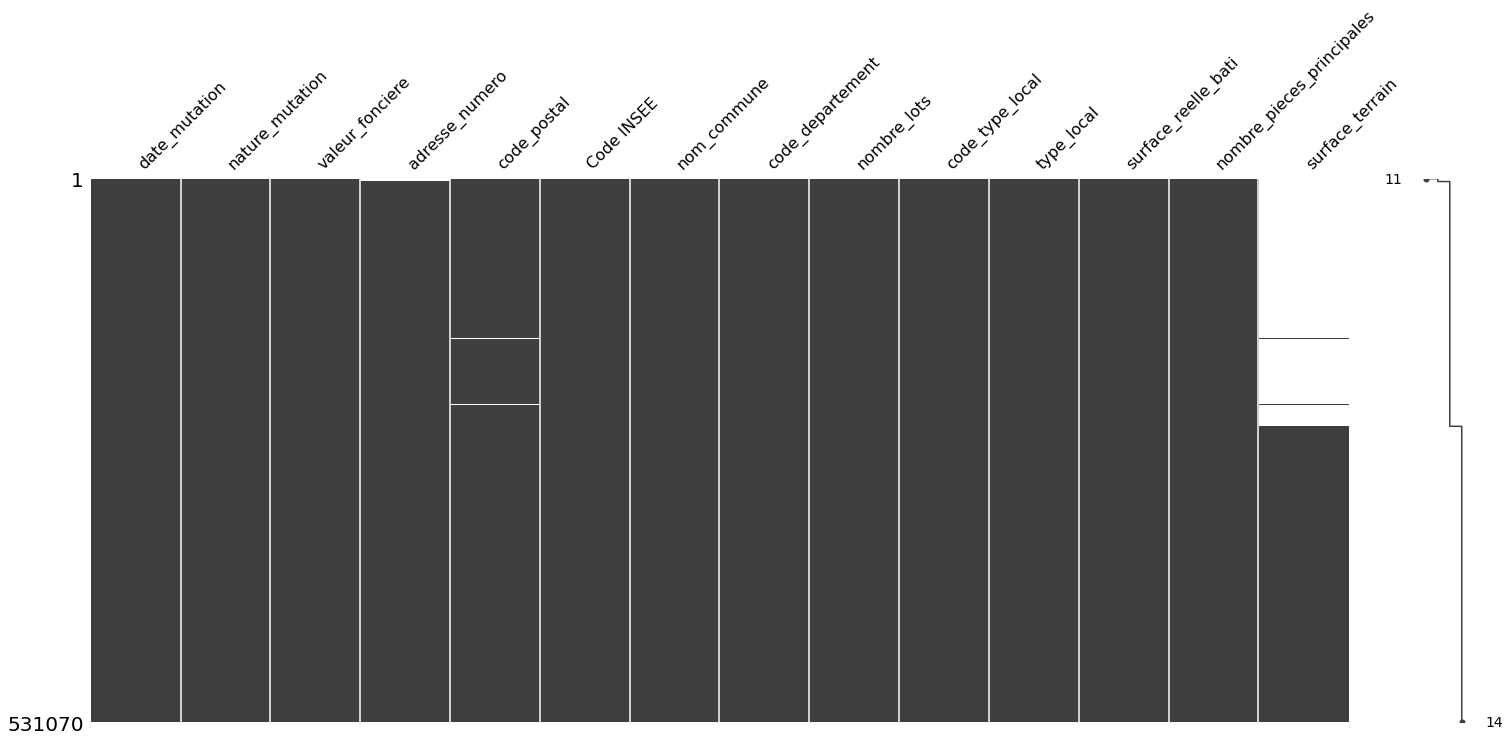

In [14]:
import missingno as msno
msno.matrix(df_MA, sort='ascending')

In [15]:
df_MA['surface_terrain'].fillna(df_MA['surface_reelle_bati'], inplace=True)


**Imputation**

In [17]:
df_MA.dropna(how='any', axis=0, inplace=True)

Ajouter les columns Years et Months

In [18]:
df_MA['Year'] = pd.DatetimeIndex(df_MA['date_mutation']).year
df_MA['Month'] = pd.DatetimeIndex(df_MA['date_mutation']).month

In [19]:
df_MA['Prix_m2']=df_MA['valeur_fonciere']/df_MA['surface_reelle_bati']

Export the data

In [21]:
df_MA.to_csv(r'datasets/fonciere_geo.csv', index = None, header=True)

# EDA

In [22]:
df_MA['code_departement'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21,
       22, 23, 24, 25, 26, 27, 28, '28', '29', '2A', '30', 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 69, 70,
       71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
       89, 90, 91, 92, 93, 94, 95, 971, 972, 973, 974, 75, 15, 29, '2B'],
      dtype=object)

In [23]:
df_MA_IDF=df_MA[(df_MA['code_departement'].isin([75,91,92,93,94,95,77,78]))]
df_MA_IDF.head()

,date_mutation,nature_mutation,valeur_fonciere,adresse_numero,code_postal,Code INSEE,nom_commune,code_departement,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,Year,Month,Prix_m2
573719,2020-01-06,Vente,257000.0,17,77170,77450,Servon,77,1,1.0,Maison,107.0,5,107.0,2020,1,2401.869159
573720,2020-01-02,Vente,320500.0,15,77380,77122,Combs-la-Ville,77,0,1.0,Maison,85.0,5,347.0,2020,1,3770.588235
573723,2020-01-08,Vente,386700.0,20,77170,77053,Brie-Comte-Robert,77,0,1.0,Maison,129.0,6,507.0,2020,1,2997.674419
573728,2020-01-09,Vente,349000.0,55,77310,77040,Boissise-le-Roi,77,0,1.0,Maison,122.0,4,854.0,2020,1,2860.655738
573756,2020-01-07,Vente,608974.0,42,77310,77407,Saint-Fargeau-Ponthierry,77,0,1.0,Maison,172.0,6,2103.0,2020,1,3540.546512


Distribution Valeur Fonciere

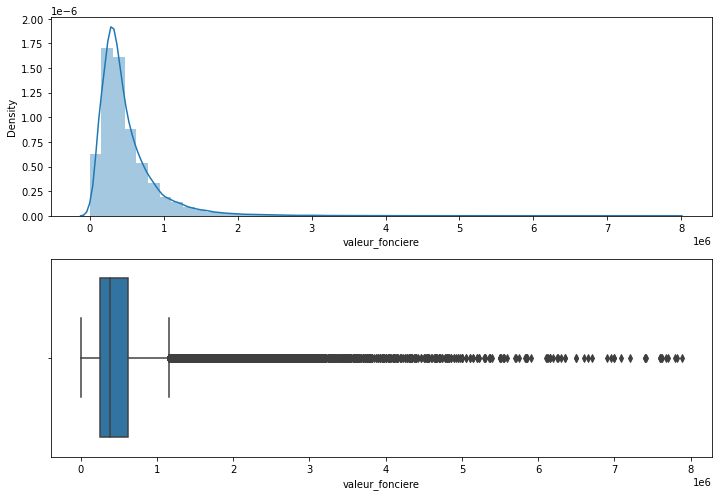

In [24]:
#visualizing valeur_fonciere
fig = plt.figure(figsize=(10,7))
fig.add_subplot(2,1,1)
sns.distplot(df_MA_IDF[df_MA_IDF['valeur_fonciere']<8000000]['valeur_fonciere'])
fig.add_subplot(2,1,2)
sns.boxplot(df_MA_IDF[df_MA_IDF['valeur_fonciere']<8000000]['valeur_fonciere'])
plt.tight_layout()

Etude corrélation des features

<AxesSubplot:>

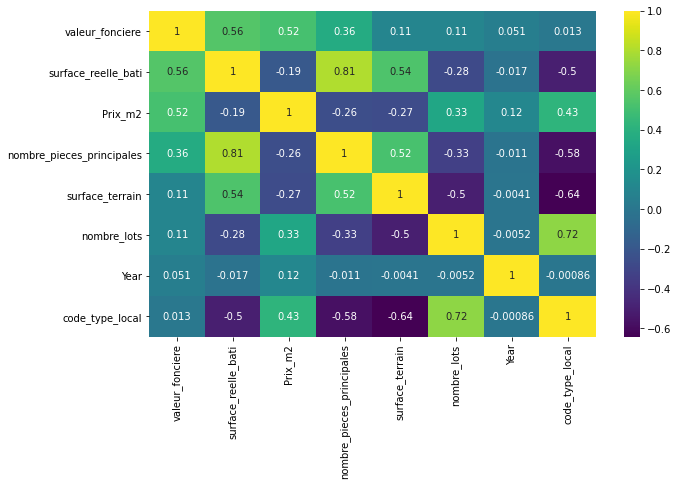

In [25]:
#correlation matrix
k = 8 #number of variables for heatmap
cols = df_MA_IDF.corr().nlargest(k, 'valeur_fonciere')['valeur_fonciere'].index
cm = df_MA_IDF[cols].corr() 
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

<AxesSubplot:xlabel='surface_terrain', ylabel='valeur_fonciere'>

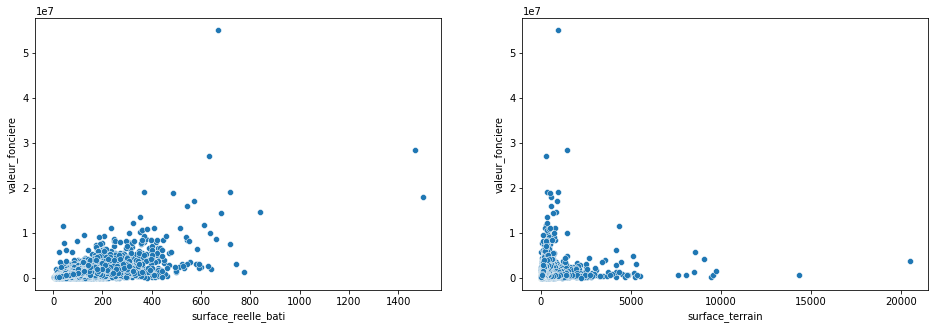

In [26]:

fig = plt.figure(figsize=(16,5))
fig.add_subplot(1,2,1)
sns.scatterplot(df_MA_IDF['surface_reelle_bati'], df_MA_IDF['valeur_fonciere'])
fig.add_subplot(1,2,2)
sns.scatterplot(df_MA_IDF['surface_terrain'],df_MA_IDF['valeur_fonciere'])

<AxesSubplot:xlabel='nombre_pieces_principales', ylabel='count'>

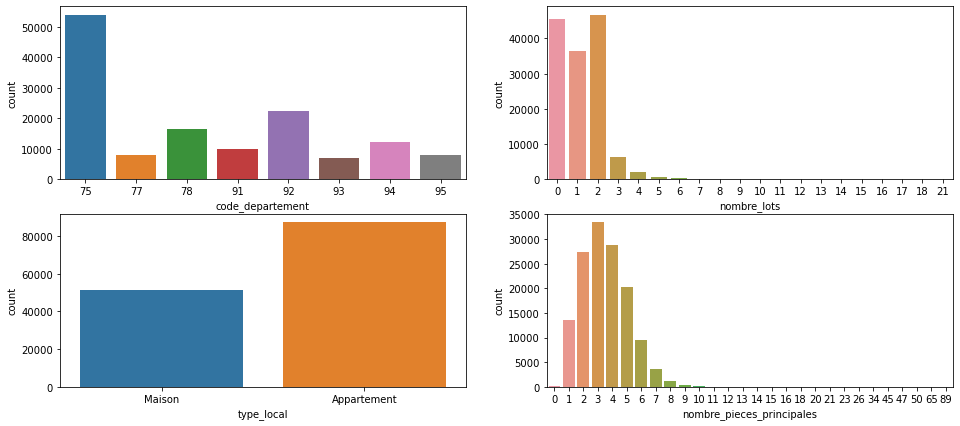

In [27]:

fig = plt.figure(figsize=(16,7))
fig.add_subplot(2,2,1)
sns.countplot(df_MA_IDF['code_departement'])
fig.add_subplot(2,2,2)
sns.countplot(df_MA_IDF['nombre_lots'])
fig.add_subplot(2,2,3)
sns.countplot(df_MA_IDF['type_local'])
fig.add_subplot(2,2,4)
sns.countplot(df_MA_IDF['nombre_pieces_principales'])

Mutation par Mois

Text(0, 0.5, 'Nombre de mutation')

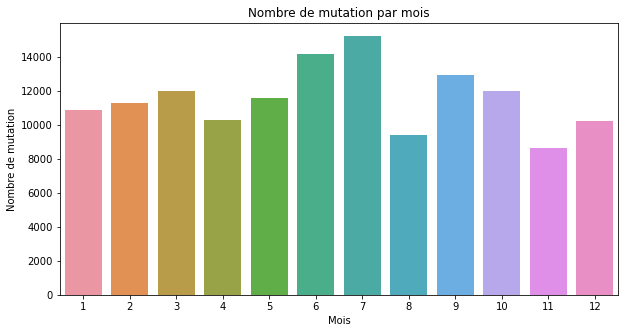

In [29]:

plt.figure(figsize=(10,5))
ax = sns.countplot(x=df_MA_IDF.Month)
ax.set_title('Nombre de mutation par mois')
ax.set_xlabel('Mois')
ax.set_ylabel('Nombre de mutation')

Text(0, 0.5, 'Nombre de mutation')

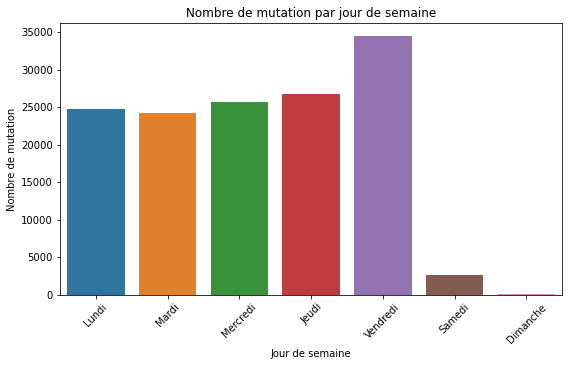

In [30]:
plt.figure(figsize=(9,5))
df_MA_IDF['jour_de_semaine'] = df_MA_IDF['date_mutation'].map(lambda x: x.dayofweek)
ax = sns.countplot(x=df_MA_IDF['jour_de_semaine'])
ax.set_title('Nombre de mutation par jour de semaine')
ax.set_xlabel('Jour de semaine')
ax.set_xticklabels(['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche'],rotation=45)
ax.set_ylabel('Nombre de mutation')

Detect the outliers

In [31]:
print('The "Surface terrain" where we reach the 90th/10th quantile is :',
      df_MA_IDF['surface_terrain'].quantile(q=0.95),df_MA_IDF['surface_terrain'].quantile(q=0.10),'m2',
      '\n',
      'The "Surface reelle bati" where we reach the 95th quantile is :',
      df_MA_IDF['surface_reelle_bati'].quantile(q=0.95),'m2',
      '\n',
     'The "Nombre pieces principales" where we reach the 99,95th quantile is :',
      df_MA_IDF['nombre_pieces_principales'].quantile(q=0.9995),'piece',
     '\n',
     'The "Valeur fonciere" where we reach the 99,95th quantile is :',
      df_MA_IDF['valeur_fonciere'].quantile(q=0.8),'euros')

The "Surface terrain" where we reach the 90th/10th quantile is : 619.0 30.0 m2 
 The "Surface reelle bati" where we reach the 95th quantile is : 162.0 m2 
 The "Nombre pieces principales" where we reach the 99,95th quantile is : 11.0 piece 
 The "Valeur fonciere" where we reach the 99,95th quantile is : 695000.0 euros


{'whiskers': [<matplotlib.lines.Line2D at 0x245dc67e2e0>,
 'caps': [<matplotlib.lines.Line2D at 0x245dc67e9a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x245dc665f40>],
 'medians': [<matplotlib.lines.Line2D at 0x245dc6490a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x245dc649400>],
 'means': []}

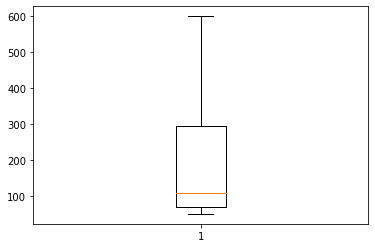

In [32]:
df_test = df_MA_IDF[(df_MA_IDF['surface_terrain']<600.0)&(df_MA_IDF['surface_terrain']>50.0)]
plt.boxplot(df_test['surface_terrain'])


{'whiskers': [<matplotlib.lines.Line2D at 0x2457ac62f40>,
 'caps': [<matplotlib.lines.Line2D at 0x245b992b640>,
 'boxes': [<matplotlib.lines.Line2D at 0x2457ac62be0>],
 'medians': [<matplotlib.lines.Line2D at 0x245b992bd00>],
 'fliers': [<matplotlib.lines.Line2D at 0x245b991d0a0>],
 'means': []}

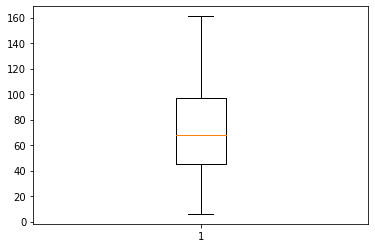

In [33]:
df_test = df_MA_IDF[(df_MA_IDF['surface_reelle_bati']<162)&(df_MA_IDF['surface_reelle_bati']>5)]
plt.boxplot(df_test['surface_reelle_bati'])

Outliers pour Nombre pieces principales

{'whiskers': [<matplotlib.lines.Line2D at 0x245e829aa60>,
 'caps': [<matplotlib.lines.Line2D at 0x245e82a8160>,
 'boxes': [<matplotlib.lines.Line2D at 0x245e829a700>],
 'medians': [<matplotlib.lines.Line2D at 0x245e82a8820>],
 'fliers': [<matplotlib.lines.Line2D at 0x245e82a8b80>],
 'means': []}

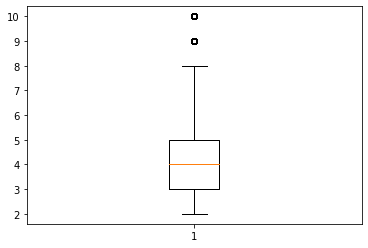

In [34]:
df_test = df_MA_IDF[(df_MA_IDF['nombre_pieces_principales']<11)&(df_MA_IDF['nombre_pieces_principales']>1)]
plt.boxplot(df_test['nombre_pieces_principales'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2456553d5b0>,
 'caps': [<matplotlib.lines.Line2D at 0x2456553dc70>,
 'boxes': [<matplotlib.lines.Line2D at 0x2456553d250>],
 'medians': [<matplotlib.lines.Line2D at 0x2456676a370>],
 'fliers': [<matplotlib.lines.Line2D at 0x2456676a6d0>],
 'means': []}

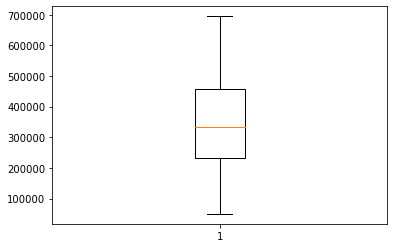

In [35]:
df_test = df_MA_IDF[(df_MA_IDF['valeur_fonciere']<695000)&(df_MA_IDF['valeur_fonciere']>50000)]
plt.boxplot(df_test['valeur_fonciere'])

Construire le dataframe final

The "Surface terrain" where we reach the 90th/10th quantile is : 702.0 159.0 m2 
 The "Surface reelle bati" where we reach the 95th quantile is : 185.0 m2 
 The "Nombre pieces principales" where we reach the 99,95th quantile is : 13.0 piece 
 The "Valeur fonciere" where we reach the 99,95th quantile is : 655119.9999999998 euros

In [36]:
df_fonciere_final = df_MA_IDF[(df_MA_IDF['valeur_fonciere']<695000)&(df_MA_IDF['valeur_fonciere']>50000)&
                     (df_MA_IDF['nombre_pieces_principales']<11)&(df_MA_IDF['nombre_pieces_principales']>1)&
                       (df_MA_IDF['surface_terrain']<600)&(df_MA_IDF['surface_terrain']>50)&
                     (df_MA_IDF['surface_reelle_bati']<162)&(df_MA_IDF['surface_reelle_bati']>5)]

df_fonciere_final.head()

,date_mutation,nature_mutation,valeur_fonciere,adresse_numero,code_postal,Code INSEE,nom_commune,code_departement,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,Year,Month,Prix_m2,jour_de_semaine
573719,2020-01-06,Vente,257000.0,17,77170,77450,Servon,77,1,1.0,Maison,107.0,5,107.0,2020,1,2401.869159,0
573720,2020-01-02,Vente,320500.0,15,77380,77122,Combs-la-Ville,77,0,1.0,Maison,85.0,5,347.0,2020,1,3770.588235,3
573723,2020-01-08,Vente,386700.0,20,77170,77053,Brie-Comte-Robert,77,0,1.0,Maison,129.0,6,507.0,2020,1,2997.674419,2
573765,2020-01-09,Vente,239900.0,1,77380,77122,Combs-la-Ville,77,0,1.0,Maison,79.0,4,138.0,2020,1,3036.708861,3
573790,2020-01-02,Vente,356900.0,1,77127,77251,Lieusaint,77,0,1.0,Maison,110.0,5,404.0,2020,1,3244.545455,3


In [37]:
df_fonciere_final.drop(['date_mutation','nature_mutation','code_postal','type_local'],axis = 1, inplace = True)

In [38]:
df_fonciere_final.head()

,valeur_fonciere,adresse_numero,Code INSEE,nom_commune,code_departement,nombre_lots,code_type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,Year,Month,Prix_m2,jour_de_semaine
573719,257000.0,17,77450,Servon,77,1,1.0,107.0,5,107.0,2020,1,2401.869159,0
573720,320500.0,15,77122,Combs-la-Ville,77,0,1.0,85.0,5,347.0,2020,1,3770.588235,3
573723,386700.0,20,77053,Brie-Comte-Robert,77,0,1.0,129.0,6,507.0,2020,1,2997.674419,2
573765,239900.0,1,77122,Combs-la-Ville,77,0,1.0,79.0,4,138.0,2020,1,3036.708861,3
573790,356900.0,1,77251,Lieusaint,77,0,1.0,110.0,5,404.0,2020,1,3244.545455,3


Concat data popu 

In [39]:
all_data=pd.read_csv('datasets/all_dataset.csv')
all_data.head()

,Code INSEE,nom_comm,code_dept,code_reg,superficie_km2,lat,lng,age_mean,age_std,age_median,population,merge1,Foyer,Nbr_p_Foyer,revenue_median,revenue_inequalities,merge2,density
0,91645,VERRIERES-LE-BUISSON,91.0,11.0,9.99,48.750443,2.251713,43.180904,25.055513,46.0,15434.0,both,6224.0,15843.0,34210.0,4.2,both,1544.944945
1,77133,COURCELLES-EN-BASSEE,77.0,11.0,10.82,48.412561,3.052941,46.291262,22.518442,51.0,219.0,both,89.0,217.0,25610.0,NaN,both,20.240296
2,91378,MAUCHAMPS,91.0,11.0,3.13,48.527268,2.197182,40.643885,22.728120,44.0,273.0,both,102.0,283.0,28080.0,NaN,both,87.220447
3,77243,LAGNY-SUR-MARNE,77.0,11.0,5.79,48.873070,2.709781,38.360069,23.270647,38.0,21264.0,both,9047.0,21301.0,23290.0,3.5,both,3672.538860
4,94003,ARCUEIL,94.0,11.0,2.32,48.805880,2.333510,37.410927,22.696750,36.0,21567.0,both,8811.0,20197.0,21750.0,4.0,both,9296.120690


In [40]:
#test_df = df_final[df_final['Code INSEE']=='94003']

df_merged = pd.merge(df_fonciere_final,all_data,on='Code INSEE',how='left', indicator=True)
df_merged.head()

,valeur_fonciere,adresse_numero,Code INSEE,nom_commune,code_departement,nombre_lots,code_type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,...,age_median,population,merge1,Foyer,Nbr_p_Foyer,revenue_median,revenue_inequalities,merge2,density,_merge
0,257000.0,17,77450,Servon,77,1,1.0,107.0,5,107.0,...,40.0,3233.0,both,1225.0,3328.0,28500.0,2.8,both,438.075881,both
1,320500.0,15,77122,Combs-la-Ville,77,0,1.0,85.0,5,347.0,...,37.0,22212.0,both,8368.0,22173.0,23470.0,3.1,both,1525.549451,both
2,386700.0,20,77053,Brie-Comte-Robert,77,0,1.0,129.0,6,507.0,...,36.0,17200.0,both,7468.0,17477.0,23290.0,3.0,both,863.453815,both
3,239900.0,1,77122,Combs-la-Ville,77,0,1.0,79.0,4,138.0,...,37.0,22212.0,both,8368.0,22173.0,23470.0,3.1,both,1525.549451,both
4,356900.0,1,77251,Lieusaint,77,0,1.0,110.0,5,404.0,...,29.0,13363.0,both,4546.0,12673.0,22200.0,2.8,both,1121.998321,both


In [41]:
df_merged[df_merged['code_departement']==75]

,valeur_fonciere,adresse_numero,Code INSEE,nom_commune,code_departement,nombre_lots,code_type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,...,age_median,population,merge1,Foyer,Nbr_p_Foyer,revenue_median,revenue_inequalities,merge2,density,_merge
4331,544000.0,35,75101,Paris 1er Arrondissement,75,1,2.0,52.0,2,52.0,...,40.0,16252.0,both,8533.0,15560.0,32890.0,7.2,both,8979.005525,both
4332,605000.0,21,75108,Paris 8e Arrondissement,75,2,2.0,61.0,3,61.0,...,38.0,36453.0,both,17387.0,37343.0,41270.0,8.6,both,9468.311688,both
4333,632000.0,10,75101,Paris 1er Arrondissement,75,1,2.0,103.0,3,103.0,...,40.0,16252.0,both,8533.0,15560.0,32890.0,7.2,both,8979.005525,both
4334,625000.0,119,75101,Paris 1er Arrondissement,75,1,2.0,52.0,3,52.0,...,40.0,16252.0,both,8533.0,15560.0,32890.0,7.2,both,8979.005525,both
4335,51875.0,53,75108,Paris 8e Arrondissement,75,4,2.0,118.0,3,118.0,...,38.0,36453.0,both,17387.0,37343.0,41270.0,8.6,both,9468.311688,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62951,510000.0,113,75104,Paris 4e Arrondissement,75,3,2.0,52.0,2,52.0,...,39.0,27487.0,both,14043.0,25626.0,31200.0,6.7,both,17179.375000,both
62952,504000.0,2,75104,Paris 4e Arrondissement,75,2,2.0,58.0,3,58.0,...,39.0,27487.0,both,14043.0,25626.0,31200.0,6.7,both,17179.375000,both
62953,613000.0,10,75102,Paris 2e Arrondissement,75,2,2.0,55.0,2,55.0,...,35.0,20260.0,both,11557.0,20803.0,31470.0,7.1,both,20464.646465,both
62954,507850.0,199,75102,Paris 2e Arrondissement,75,2,2.0,64.0,3,64.0,...,35.0,20260.0,both,11557.0,20803.0,31470.0,7.1,both,20464.646465,both


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

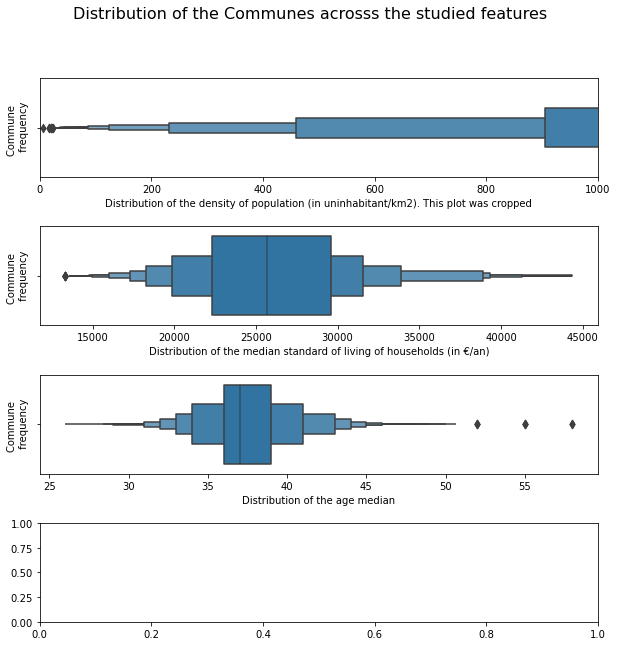

In [42]:
# Define subplots object
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,10) , gridspec_kw={'hspace': 0.5})

fig.suptitle('Distribution of the Communes acrosss the studied features', fontsize=16)

# Plot density
sns.boxenplot(df_merged['density'],ax=ax1)
ax1.set_xlabel('Distribution of the density of population (in uninhabitant/km2). This plot was cropped')
ax1.set_ylabel('Commune \n frequency')
ax1.set_xlim(0,1000)

# Plot revenue_median
sns.boxenplot(df_merged['revenue_median'],ax=ax2)
ax2.set_xlabel('Distribution of the median standard of living of households (in €/an)')
ax2.set_ylabel('Commune \n frequency')

# Plot age_median
sns.boxenplot(df_merged['age_median'],ax=ax3)
ax3.set_xlabel('Distribution of the age median')
ax3.set_ylabel('Commune \n frequency')

# Plot Prix_m2
sns.boxenplot(df_merged['Prix_m2'],ax=ax4)
ax4.set_xlabel('Distribution of the mean price of houses per m2 ( in €/m2). This plot was cropped ')
ax4.set_ylabel('Commune \n frequency')
ax4.set_xlim(0,6000)

In [43]:
print(df_merged.shape)

(62956, 32)


In [44]:
print(df_merged.shape)
df_merged.dropna(how='any', axis=0, inplace=True)
print(df_merged.shape)

(62956, 32)
(61224, 32)


In [45]:
df_merged.to_csv('datasets/df_merged_dataset.csv', index=False)

**Encode**

In [46]:
df_merged.columns

Index(['valeur_fonciere', 'adresse_numero', 'Code INSEE', 'nom_commune',
       'code_departement', 'nombre_lots', 'code_type_local',
       'surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain',
       'Year', 'Month', 'Prix_m2', 'jour_de_semaine', 'nom_comm', 'code_dept',
       'code_reg', 'superficie_km2', 'lat', 'lng', 'age_mean', 'age_std',
       'age_median', 'population', 'merge1', 'Foyer', 'Nbr_p_Foyer',
       'revenue_median', 'revenue_inequalities', 'merge2', 'density',
       '_merge'],
      dtype='object')

Fonction graphe

In [205]:
def plotmodel(ytest,ypred) :
    width=7
    height=5
    plt.figure(figsize=(width, height))


    ax1 = sns.distplot(ytest, hist=False, color="r", label="test Value")
    sns.distplot(ypred, hist=False, color="b", label="Fit Values" , ax=ax1)


    plt.title('Actual vs pred')
    plt.xlabel('Prix')
    plt.ylabel('Densité')

    plt.show()
    plt.close()

# Machine learning

Dataset Preparation (Splitting and Scaling)

In [47]:
from sklearn.model_selection import train_test_split

numeric_features = ['nombre_lots','surface_reelle_bati','nombre_pieces_principales','surface_terrain','superficie_km2',
                    'age_median','revenue_median','population','density']
categorical_features = ['adresse_numero','code_type_local','Month','code_departement']

col_X = numeric_features+categorical_features

X = df_merged[col_X].values
y = df_merged['valeur_fonciere'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [48]:
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))

LinearRegression

In [158]:
# Multiple Liner Regression
from sklearn.linear_model import LinearRegression
model_regressor = LinearRegression()  
model_regressor.fit(X_train, y_train)

#evaluate the model (intercept and slope)
print(model_regressor.intercept_)
print(model_regressor.coef_)

#predicting the test set result
y_pred_model1 = model_regressor.predict(X_test)


-133952.6
[ 2.9116514e+03  1.8776770e+03 -3.3388447e+03  4.2979988e+01
  3.8510312e+02 -1.3831154e+03  1.3232124e+01  6.6430664e-01
  7.8502808e+00 -5.8495264e+00 -8.4918266e+04  2.8846930e+02
  9.1893115e+02]


In [159]:
print("model R2 score: %.3f" % model_regressor.score(X_test, y_test))

from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, y_pred_model1)
print('model regressor MSE is: ', MSE)


model R2 score: 0.533
model regressor MSE is:  10849682314.1255


In [160]:
#score collector
score_data = {'Model':['LinearRegression'],'R2':[model_regressor.score(X_test, y_test)],'MSE':[MSE]}
score_collector = pd.DataFrame(score_data)
score_collector

,Model,R2,MSE
0,LinearRegression,0.533473,1.084968e+10


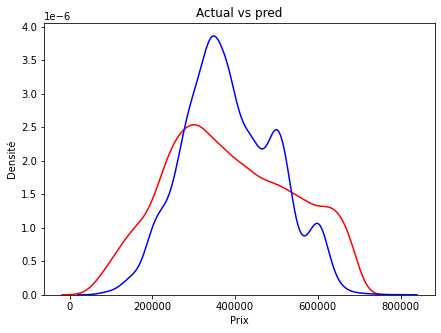

<AxesSubplot:ylabel='Density'>

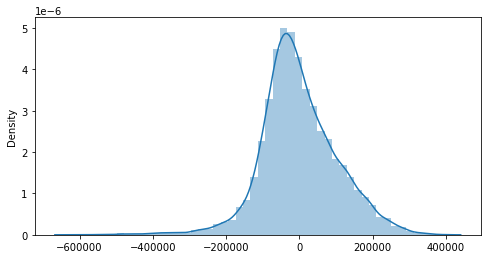

In [162]:
# Distribution predicted prix et actual prix
plotmodel(y_test, y_pred_model1)

# visualizing residuals
fig = plt.figure(figsize=(8,4))
residuals = (y_test- y_pred_model1)
sns.distplot(residuals)

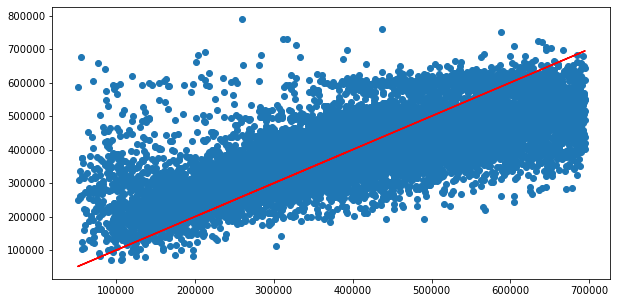

In [208]:
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred_model1)
# Perfect predictions
plt.plot(y_test,y_test,'r')

Ensemble Learning -Boosting -Xgboost

In [54]:
import xgboost as xgb 

model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 200, verbosity=1)

model_xgb.fit(X_train, y_train)
print("model score: %.3f" % model_xgb.score(X_test, y_test))

model score: 0.683


XGBoosting with GridSearch

In [55]:
from sklearn.model_selection import GridSearchCV

# Round 1 Grid search for n_estimators
xgb_model_r1 = xgb.XGBRegressor(max_depth=5,learning_rate= 0.1, verbosity=1, 
                              objective='reg:squarederror',random_state=1)

grid_r1= GridSearchCV(xgb_model_r1, {'n_estimators': [20,50,100,150,200]}, scoring='neg_mean_squared_error', cv=10)
grid_r1.fit(X_train,y_train)

#get the best score and parameters

print(grid_r1.best_score_)
print(grid_r1.best_params_)



-7020554250.198816
{'n_estimators': 200}


In [56]:
# Round 2 Grid search for max_depth and min_child_weight
xgb_model_r2 = xgb.XGBRegressor(n_estimators=200, learning_rate= 0.1, verbosity=1,
                                 objective='reg:squarederror',random_state=1)
param_r2 = {
 'max_depth':range(3,12,1),
 'min_child_weight':range(1,6,2)}

grid_r2= GridSearchCV(xgb_model_r2, param_grid = param_r2, scoring='neg_mean_squared_error', cv=10)
grid_r2.fit(X_train,y_train)

#get the best score and parameters
print(grid_r2.best_score_)
print(grid_r2.best_params_)

-6909028069.351796
{'max_depth': 7, 'min_child_weight': 5}


In [164]:
xgb_model_final = xgb.XGBRegressor(n_estimators=200, max_depth=7, min_child_weight=1, learning_rate= 0.1, verbosity=1,
                                   objective='reg:squarederror',random_state=1)

xgb_model_final.fit(X_train,y_train)
y_pred_final = xgb_model_final.predict(X_test)

print("model R2 score: %.3f" % xgb_model_final.score(X_test, y_test))
MSE_xgb_test = mean_squared_error(y_test, y_pred_final)
print('model xgboost MSE is: ', MSE_xgb_test)

model R2 score: 0.700
model xgboost MSE is:  6968045653.300115


In [165]:
#score collector

score_collector=score_collector.append({'Model':'XGBRegressor','R2':xgb_model_final.score(X_test, y_test),'MSE':MSE_xgb_test}, ignore_index=True)

score_collector

,Model,R2,MSE
0,LinearRegression,0.533473,1.084968e+10
1,XGBRegressor,0.700380,6.968046e+09


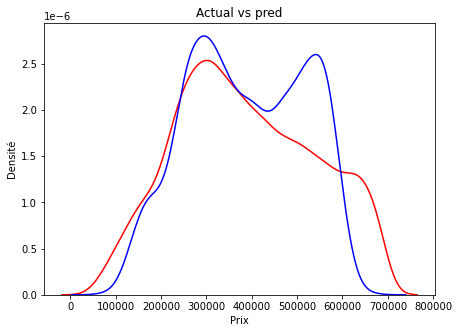

<AxesSubplot:ylabel='Density'>

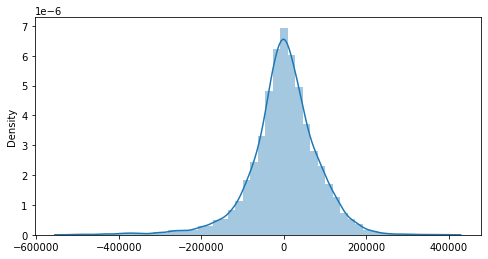

In [166]:
# Distribution predicted prix et actual prix
plotmodel(y_test, y_pred_final)

# visualizing residuals
fig = plt.figure(figsize=(8,4))
residuals = (y_test- y_pred_final)
sns.distplot(residuals)

Ensemble Learning -Bagging -RandomForestRegressor

In [60]:
from sklearn.ensemble import RandomForestRegressor

#Grid CV round1
param_test1 = {'n_estimators':[10,20,40,60,80,100,150,200]}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=100,min_samples_leaf=20,
                                                          max_depth=8,max_features='auto' ,random_state=10), 
                        param_grid = param_test1, scoring='neg_mean_squared_error',cv=10, verbose=1)

gsearch1.fit(X_train,y_train)

#get the best score and parameters
print(gsearch1.best_score_)
print(gsearch1.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  6.8min finished


-7844177260.806643
{'n_estimators': 200}


In [61]:
#Grid CV round2
param_test2 = {'max_depth':[3,5,7,9,11,13], 'min_samples_split':[50,70,90,110,130,150,170,190]}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 150, min_samples_leaf=20,
                                                           max_features='auto',oob_score=True, random_state=10),
                        param_grid = param_test2, scoring='neg_mean_squared_error',iid=False, cv=10, verbose=1)

gsearch2.fit(X_train,y_train)

#get the best score and parameters
print(gsearch2.best_score_)
print(gsearch2.best_params_)


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 70.7min finished


-7208592404.664482
{'max_depth': 13, 'min_samples_split': 50}


In [62]:
#validation data)
rf1 = RandomForestRegressor(n_estimators= 150, max_depth=13, min_samples_split=50,
                                  min_samples_leaf=20,max_features='auto' ,oob_score=True, random_state=10)
rf1.fit(X_train,y_train)
#
print (rf1.oob_score_)

0.6920295468334512


In [167]:
rf_model_final = RandomForestRegressor(n_estimators= 150, max_depth=13 , min_samples_split=50,min_samples_leaf=20,
                                       max_features='auto', random_state=10)

rf_model_final.fit(X_train,y_train)
y_pred_rf_final = rf_model_final.predict(X_test)

print("model R2 score: %.3f" % rf_model_final.score(X_test, y_test))
MSE_rf_test = mean_squared_error(y_test, y_pred_rf_final)
print('model Random Forest MSE is: ', MSE_rf_test)

model R2 score: 0.688
model Random Forest MSE is:  7262022960.978384


In [168]:
#score collector

score_collector=score_collector.append({'Model':'RandomForestRegressor','R2':rf_model_final.score(X_test, y_test),'MSE':MSE_rf_test}, ignore_index=True)

score_collector

,Model,R2,MSE
0,LinearRegression,0.533473,1.084968e+10
1,XGBRegressor,0.700380,6.968046e+09
2,RandomForestRegressor,0.687739,7.262023e+09


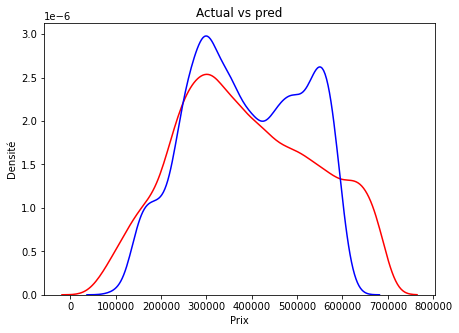

<AxesSubplot:ylabel='Density'>

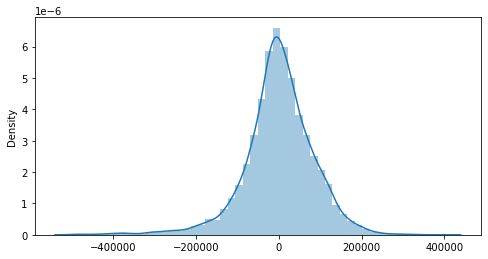

In [169]:
# Distribution predicted prix et actual prix
plotmodel(y_test, y_pred_rf_final)

# visualizing residuals
fig = plt.figure(figsize=(8,4))
residuals = (y_test- y_pred_rf_final)
sns.distplot(residuals)

# Deep Learning neural network model

Split data in train, validation and test data

In [65]:
X = np.asarray(X).astype('float32')

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
    
print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(61224, 13)
(36734, 13)
(12245, 13)
(12245, 13)


In [66]:
# Creating a Neural Network Model
from tensorflow.keras.models import Sequential
from keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [67]:
# Build neuron model
model_dl = Sequential() 
model_dl.add(layers.Dense(64, activation='relu',input_shape=(X_train.shape[1],))) 
model_dl.add(layers.Dense(64, activation='relu'))
model_dl.add(layers.Dense(64, activation='relu'))
model_dl.add(layers.Dense(1))

model_dl.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,281
Trainable params: 9,281
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Adam optimiser MAE loss，mean absolute error)
model_dl.compile(optimizer='Adam', loss='mse', metrics=['mae'])

#fit
model_dl.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
             epochs=500, batch_size=128, verbose=1)


Epoch 1/500
287/287 [==============================] - 1s 2ms/step - loss: 37416747008.0000 - mae: 144096.0938 - val_loss: 14917073920.0000 - val_mae: 96382.7969
Epoch 2/500
287/287 [==============================] - 0s 861us/step - loss: 14658473984.0000 - mae: 95329.5000 - val_loss: 14578128896.0000 - val_mae: 95062.4688
Epoch 3/500
287/287 [==============================] - 0s 834us/step - loss: 14390757376.0000 - mae: 94332.9141 - val_loss: 14446290944.0000 - val_mae: 94577.9219
Epoch 4/500
287/287 [==============================] - 0s 825us/step - loss: 14079041536.0000 - mae: 93204.7500 - val_loss: 13932697600.0000 - val_mae: 92577.6094
Epoch 5/500
287/287 [==============================] - 0s 836us/step - loss: 13676538880.0000 - mae: 91775.0391 - val_loss: 13535930368.0000 - val_mae: 91190.7031
Epoch 6/500
287/287 [==============================] - 0s 830us/step - loss: 13190585344.0000 - mae: 89963.0391 - val_loss: 13036129280.0000 - val_mae: 90102.5781
Epoch 7/500
287/287 [==

287/287 [==============================] - 0s 901us/step - loss: 9933877248.0000 - mae: 74976.5625 - val_loss: 9681883136.0000 - val_mae: 74888.0312
Epoch 52/500
287/287 [==============================] - 0s 946us/step - loss: 9833167872.0000 - mae: 74694.6641 - val_loss: 9796503552.0000 - val_mae: 74551.3359
Epoch 53/500
287/287 [==============================] - 0s 832us/step - loss: 9820562432.0000 - mae: 74481.8438 - val_loss: 10030696448.0000 - val_mae: 75383.9531
Epoch 54/500
287/287 [==============================] - 0s 829us/step - loss: 9844639744.0000 - mae: 74703.0547 - val_loss: 10347851776.0000 - val_mae: 77150.9375
Epoch 55/500
287/287 [==============================] - 0s 776us/step - loss: 9718295552.0000 - mae: 74004.9219 - val_loss: 9586341888.0000 - val_mae: 73984.5000
Epoch 56/500
287/287 [==============================] - 0s 773us/step - loss: 9897856000.0000 - mae: 74909.4375 - val_loss: 9765274624.0000 - val_mae: 74106.2656
Epoch 57/500
287/287 [=================

287/287 [==============================] - 0s 1ms/step - loss: 9446772736.0000 - mae: 72760.2031 - val_loss: 9302996992.0000 - val_mae: 72741.3828
Epoch 102/500
287/287 [==============================] - 1s 2ms/step - loss: 9525924864.0000 - mae: 73079.4297 - val_loss: 9265850368.0000 - val_mae: 72532.0547
Epoch 103/500
287/287 [==============================] - 0s 1ms/step - loss: 9416101888.0000 - mae: 72578.5078 - val_loss: 9548482560.0000 - val_mae: 73943.0312
Epoch 104/500
287/287 [==============================] - 1s 3ms/step - loss: 9459354624.0000 - mae: 72701.5391 - val_loss: 9473361920.0000 - val_mae: 73788.0469
Epoch 105/500
287/287 [==============================] - 0s 918us/step - loss: 9579538432.0000 - mae: 73308.7031 - val_loss: 9695336448.0000 - val_mae: 74535.5938
Epoch 106/500
287/287 [==============================] - 0s 782us/step - loss: 9409458176.0000 - mae: 72572.8438 - val_loss: 9339616256.0000 - val_mae: 72550.0859
Epoch 107/500
287/287 [=====================

287/287 [==============================] - 0s 872us/step - loss: 9224728576.0000 - mae: 71694.4844 - val_loss: 9131508736.0000 - val_mae: 72064.9844
Epoch 152/500
287/287 [==============================] - 0s 797us/step - loss: 9228937216.0000 - mae: 71709.1797 - val_loss: 9096458240.0000 - val_mae: 71925.7500
Epoch 153/500
287/287 [==============================] - 0s 845us/step - loss: 9232836608.0000 - mae: 71850.8047 - val_loss: 9248890880.0000 - val_mae: 72400.2578
Epoch 154/500
287/287 [==============================] - 0s 817us/step - loss: 9245840384.0000 - mae: 71833.4531 - val_loss: 9220777984.0000 - val_mae: 72231.2422
Epoch 155/500
287/287 [==============================] - 0s 827us/step - loss: 9208506368.0000 - mae: 71682.1250 - val_loss: 9206441984.0000 - val_mae: 72050.6172
Epoch 156/500
287/287 [==============================] - 0s 778us/step - loss: 9186794496.0000 - mae: 71555.2500 - val_loss: 9247012864.0000 - val_mae: 72471.4922
Epoch 157/500
287/287 [=============

287/287 [==============================] - 0s 790us/step - loss: 9155501056.0000 - mae: 71451.3750 - val_loss: 8989177856.0000 - val_mae: 71338.0469
Epoch 202/500
287/287 [==============================] - 0s 818us/step - loss: 9097536512.0000 - mae: 71189.1484 - val_loss: 9013739520.0000 - val_mae: 71377.4219
Epoch 203/500
287/287 [==============================] - 0s 806us/step - loss: 9106808832.0000 - mae: 71192.9297 - val_loss: 9215394816.0000 - val_mae: 72880.5547
Epoch 204/500
287/287 [==============================] - 0s 801us/step - loss: 9149556736.0000 - mae: 71417.5469 - val_loss: 8974301184.0000 - val_mae: 70776.8828
Epoch 205/500
287/287 [==============================] - 0s 827us/step - loss: 9154095104.0000 - mae: 71457.0000 - val_loss: 9034302464.0000 - val_mae: 71562.7188
Epoch 206/500
287/287 [==============================] - 0s 824us/step - loss: 9106962432.0000 - mae: 71247.8125 - val_loss: 9274084352.0000 - val_mae: 72732.1953
Epoch 207/500
287/287 [=============

287/287 [==============================] - 0s 1ms/step - loss: 8995620864.0000 - mae: 70579.1797 - val_loss: 8874814464.0000 - val_mae: 70135.6250
Epoch 252/500
287/287 [==============================] - 0s 1ms/step - loss: 8922127360.0000 - mae: 70225.9297 - val_loss: 8926931968.0000 - val_mae: 70803.9688
Epoch 253/500
287/287 [==============================] - 0s 1ms/step - loss: 8952100864.0000 - mae: 70494.3438 - val_loss: 8992840704.0000 - val_mae: 70563.0469
Epoch 254/500
287/287 [==============================] - 0s 860us/step - loss: 9013457920.0000 - mae: 70778.0312 - val_loss: 8864619520.0000 - val_mae: 70575.3906
Epoch 255/500
287/287 [==============================] - 0s 861us/step - loss: 8976759808.0000 - mae: 70554.3672 - val_loss: 8965959680.0000 - val_mae: 70764.0859
Epoch 256/500
287/287 [==============================] - 0s 832us/step - loss: 8992739328.0000 - mae: 70678.3438 - val_loss: 8925334528.0000 - val_mae: 70457.7188
Epoch 257/500
287/287 [===================

287/287 [==============================] - 0s 935us/step - loss: 8855706624.0000 - mae: 69979.7734 - val_loss: 9037807616.0000 - val_mae: 70706.2188
Epoch 302/500
287/287 [==============================] - 0s 822us/step - loss: 8773241856.0000 - mae: 69581.7344 - val_loss: 8789300224.0000 - val_mae: 70104.5234
Epoch 303/500
287/287 [==============================] - 0s 867us/step - loss: 8809651200.0000 - mae: 69731.7188 - val_loss: 8776911872.0000 - val_mae: 70038.0938
Epoch 304/500
287/287 [==============================] - 0s 764us/step - loss: 8804943872.0000 - mae: 69846.4688 - val_loss: 8861814784.0000 - val_mae: 70126.5312
Epoch 305/500
287/287 [==============================] - 0s 772us/step - loss: 8867762176.0000 - mae: 70071.0312 - val_loss: 8738044928.0000 - val_mae: 69370.0234
Epoch 306/500
287/287 [==============================] - 0s 778us/step - loss: 8795038720.0000 - mae: 69798.1797 - val_loss: 8781123584.0000 - val_mae: 70054.7578
Epoch 307/500
287/287 [=============

287/287 [==============================] - 0s 780us/step - loss: 8680836096.0000 - mae: 69254.9688 - val_loss: 8884248576.0000 - val_mae: 70600.8516
Epoch 352/500
287/287 [==============================] - 0s 816us/step - loss: 8656671744.0000 - mae: 69123.3281 - val_loss: 8807323648.0000 - val_mae: 69452.3828
Epoch 353/500
287/287 [==============================] - 0s 825us/step - loss: 8676049920.0000 - mae: 69132.0156 - val_loss: 8744911872.0000 - val_mae: 69067.7656
Epoch 354/500
287/287 [==============================] - 0s 832us/step - loss: 8687069184.0000 - mae: 69125.6641 - val_loss: 9854918656.0000 - val_mae: 74557.6094
Epoch 355/500
287/287 [==============================] - 0s 794us/step - loss: 8764539904.0000 - mae: 69595.8594 - val_loss: 8706663424.0000 - val_mae: 69282.0781
Epoch 356/500
287/287 [==============================] - 0s 815us/step - loss: 8708843520.0000 - mae: 69264.9062 - val_loss: 9404738560.0000 - val_mae: 72033.3438
Epoch 357/500
287/287 [=============

287/287 [==============================] - 0s 774us/step - loss: 8612954112.0000 - mae: 68920.1797 - val_loss: 8704226304.0000 - val_mae: 70177.8828
Epoch 402/500
287/287 [==============================] - 0s 773us/step - loss: 8731678720.0000 - mae: 69431.6016 - val_loss: 8557181440.0000 - val_mae: 68754.7031
Epoch 403/500
287/287 [==============================] - 0s 794us/step - loss: 8608492544.0000 - mae: 68931.6641 - val_loss: 8936726528.0000 - val_mae: 70410.5547
Epoch 404/500
287/287 [==============================] - 0s 852us/step - loss: 8597626880.0000 - mae: 68816.5938 - val_loss: 8903832576.0000 - val_mae: 71044.1016
Epoch 405/500
287/287 [==============================] - 0s 775us/step - loss: 8620529664.0000 - mae: 68926.5078 - val_loss: 8530521088.0000 - val_mae: 68263.0078
Epoch 406/500
287/287 [==============================] - 0s 822us/step - loss: 8546256384.0000 - mae: 68685.1875 - val_loss: 8822078464.0000 - val_mae: 70046.0859
Epoch 407/500
287/287 [=============

287/287 [==============================] - 0s 827us/step - loss: 8515134464.0000 - mae: 68404.4531 - val_loss: 8407109632.0000 - val_mae: 67844.3203
Epoch 452/500
287/287 [==============================] - 0s 828us/step - loss: 8499210240.0000 - mae: 68228.3594 - val_loss: 8432762368.0000 - val_mae: 68168.8359
Epoch 453/500
287/287 [==============================] - 0s 828us/step - loss: 8474499072.0000 - mae: 68198.0000 - val_loss: 8457469952.0000 - val_mae: 68386.4453
Epoch 454/500
287/287 [==============================] - 0s 778us/step - loss: 8623687680.0000 - mae: 68913.2812 - val_loss: 8899503104.0000 - val_mae: 69969.5781
Epoch 455/500
287/287 [==============================] - 0s 825us/step - loss: 8470944768.0000 - mae: 68242.2344 - val_loss: 8495158272.0000 - val_mae: 68559.6719
Epoch 456/500
287/287 [==============================] - 0s 827us/step - loss: 8489664000.0000 - mae: 68296.5234 - val_loss: 8660707328.0000 - val_mae: 69120.7734
Epoch 457/500
287/287 [=============

Text(0, 0.5, 'Metric')

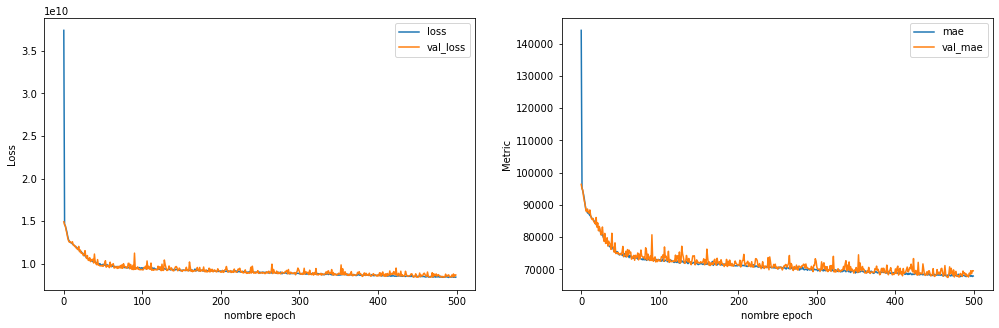

In [69]:
#history curve
history_df = pd.DataFrame(model_dl.history.history) 


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5) , gridspec_kw={'hspace': 0.5})

history_df.loc[:,['loss','val_loss']].plot(ax=ax1)
ax1.set_xlabel('nombre epoch')
ax1.set_ylabel('Loss')

history_df.loc[:,['mae','val_mae']].plot(ax=ax2)
ax2.set_xlabel('nombre epoch')
ax2.set_ylabel('Metric')

In [170]:
y_pred_dl = model_dl.predict(X_test)
from sklearn import metrics
from sklearn.metrics import r2_score

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_dl))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred_dl))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_dl)))
print('R2:', metrics.r2_score(y_test, y_pred_dl))


MAE: 68401.04110072988
MSE: 8495661659.330331
RMSE: 92171.91361434529
R2: 0.6346940365581841


In [171]:
#score collector

score_collector=score_collector.append({'Model':'Neural network','R2':metrics.r2_score(y_test, y_pred_dl),
                                        'MSE':metrics.mean_squared_error(y_test, y_pred_dl)}, ignore_index=True)

score_collector

,Model,R2,MSE
0,LinearRegression,0.533473,1.084968e+10
1,XGBRegressor,0.700380,6.968046e+09
2,RandomForestRegressor,0.687739,7.262023e+09
3,Neural network,0.634694,8.495662e+09


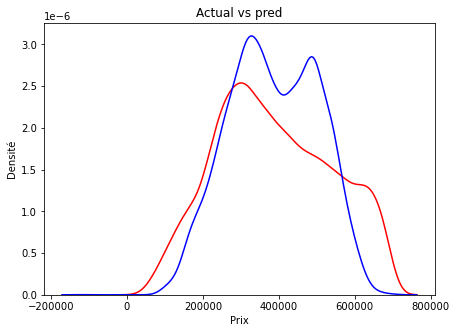

In [206]:
# Distribution predicted prix et actual prix
plotmodel(y_test, y_pred_dl)

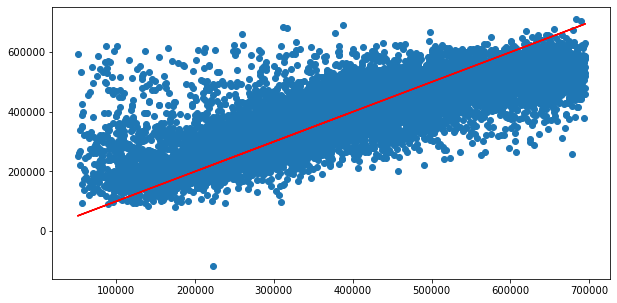

In [207]:
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred_dl)
# Perfect predictions
plt.plot(y_test,y_test,'r')

In [72]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
Nb_pieces,surface_reelle_bati, Surface_terrain, nombre_lots, code_type_local, 
             adresse_numero, code_departement, Month, superficie_km2, age_median, 
             revenue_median, population, density

In [81]:
df_merged[col_X].describe()

,nombre_lots,surface_reelle_bati,nombre_pieces_principales,surface_terrain,superficie_km2,age_median,revenue_median,population,density,adresse_numero,code_type_local,Month
count,61224.000000,61224.000000,61224.000000,61224.000000,61224.000000,61224.000000,61224.000000,61224.000000,61224.000000,61224.000000,61224.000000,61224.000000
mean,0.978374,82.275215,3.852917,192.109192,8.527808,37.412493,25991.388181,60176.995198,10188.131406,86.818519,1.469816,6.396348
std,1.098288,25.880770,1.142312,159.962708,9.687120,2.928743,5351.047196,59324.963094,10311.196282,659.931064,0.499092,3.293752
min,0.000000,17.000000,2.000000,51.000000,0.690000,28.000000,13320.000000,1905.000000,86.482567,1.000000,1.000000,1.000000
25%,0.000000,62.000000,3.000000,65.000000,4.180000,36.000000,22330.000000,18084.000000,2549.315068,8.000000,1.000000,4.000000
50%,1.000000,76.000000,4.000000,96.000000,6.440000,37.000000,25460.000000,34788.000000,6140.828402,20.000000,1.000000,6.000000
75%,2.000000,98.000000,5.000000,318.000000,10.230000,39.000000,29610.000000,85346.000000,14915.251300,47.000000,2.000000,9.000000
max,15.000000,161.000000,10.000000,599.000000,172.370000,49.000000,44370.000000,233484.000000,40168.579235,9181.000000,2.000000,12.000000


In [88]:
X_test

array([[ 0., 73.,  2., ...,  1., 10., 78.],
       [ 2., 67.,  3., ...,  2.,  9., 75.],
       [ 4., 55.,  2., ...,  2.,  5., 75.],
       ...,
       [ 2., 59.,  2., ...,  2., 10., 75.],
       [ 2., 51.,  2., ...,  2.,  5., 75.],
       [ 2., 51.,  2., ...,  2.,  8., 92.]], dtype=float32)

In [116]:
from sklearn.linear_model import LinearRegression
# Defining and trainning model to be used
lm = LinearRegression()
lm.fit(X_train,y_train)

# Defining a function to estimate the price
def estimate(Nb_pieces,surface_reelle_bati, Surface_terrain, nombre_lots, code_type_local, 
             adresse_numero, code_departement, Month, superficie_km2, age_median, 
             revenue_median, population, density):
    
    x={'nombre_pieces_principales':[Nb_pieces],
       'surface_reelle_bati':[surface_reelle_bati], 
       'surface_terrain' :[Surface_terrain],
       'nombre_lots' :[nombre_lots],
       'code_type_local' :[code_type_local],
       'adresse_numero' :[adresse_numero],
       'code_departement' :[code_departement],
       'Month' :[Month],
       'superficie_km2' :[superficie_km2],
       'age_median' :[age_median],
       'revenue_median' :[revenue_median],
       'population' :[population],
       'density' :[density],
      }, 
    
    x_estim=pd.DataFrame.from_dict(x, orient='columns')
    x_estim= np.array(x_estim)
    x_estim = s_scaler.transform(x_estim.astype(np.float))
    return print('Estimated price :',lm.predict(x_estim)[0])

In [ ]:
numeric_features = ['nombre_lots','surface_reelle_bati','nombre_pieces_principales','surface_terrain',
                    'superficie_km2',
                    'age_median','revenue_median','population','density']
categorical_features = ['adresse_numero','code_type_local','Month','code_departement']

col_X = numeric_features+categorical_features
X = df_merged[col_X].values
y = df_merged['valeur_fonciere'].values

In [145]:
df_estimator = df_merged[df_merged['code_departement']==78][['code_departement','superficie_km2',
                    'age_median','revenue_median','population','density']]
df_estimator.groupby(['code_departement']).mean()

,superficie_km2,age_median,revenue_median,population,density
code_departement,,,,,
78,11.742486,38.824681,27725.146015,25846.594504,2836.135779


In [152]:
e_featuers=np.array([[4,200,5,200,6,38,27000,25000,30000,1,0,5,78]])
x_estim = s_scaler.transform(e_featuers.astype(np.float))
xgb_model_final.predict(x_estim)

array([421012.88], dtype=float32)

In [120]:
e_featuers=np.array(Nb_pieces=4,surface_reelle_bati=100, 
         Surface_terrain=100,nombre_lots=2,code_type_local=0, 
             adresse_numero=10, code_departement=78, Month=10, 
         superficie_km2=5, age_median=36, 
             revenue_median=20000, population=25000, density=30000)
e_featuers

TypeError: array() takes at most 6 keyword arguments (13 given)

In [103]:
Nb_pieces=widgets.FloatSlider(value=4,min=1, max=6, step=1, description='NB pieces')
surface_reelle_bati=widgets.FloatSlider(value=100,min=50, max=150, step=10, description='surface_bati')
Surface_terrain=widgets.FloatSlider(value=200,min=60, max=600, step=25, description='S terrain')
nombre_lots=widgets.FloatSlider(value=5,min=0, max=15, step=15, description='nombre_lots')
adresse_numero=widgets.FloatSlider(value=20,min=1, max=600, step=25, description='adresse_numero')
code_departement=widgets.FloatSlider(value=92,min=75, max=95, step=1, description='code_departement')
Month=widgets.FloatSlider(value=5,min=1, max=12, step=1, description='Month')
superficie_km2=widgets.FloatSlider(value=5,min=4, max=10, step=1, description='superficie_km2')
age_median=widgets.FloatSlider(value=36,min=28, max=49, step=2, description='age_median')
revenue_median=widgets.FloatSlider(value=20000,min=13320, max=44370, step=5000, description='revenue_median')
population=widgets.FloatSlider(value=25000,min=18084, max=85346, step=1000, description='population')
density=widgets.FloatSlider(value=30000,min=2549, max=40168, step=2500, description='density')
code_type_local=widgets.FloatSlider(value=1,min=1, max=2, step=1, description='code_type_local')


estimator_features

array([FloatSlider(value=4.0, description='NB pieces', max=6.0, min=1.0, step=1.0),
       FloatSlider(value=100.0, description='surface_bati', max=150.0, min=50.0, step=10.0),
       FloatSlider(value=200.0, description='S terrain', max=600.0, min=60.0, step=25.0),
       FloatSlider(value=5.0, description='nombre_lots', max=15.0, step=15.0),
       FloatSlider(value=1.0, description='code_type_local', max=2.0, min=1.0, step=1.0),
       FloatSlider(value=20.0, description='adresse_numero', max=600.0, min=1.0, step=25.0),
       FloatSlider(value=92.0, description='code_departement', max=95.0, min=75.0, step=1.0),
       FloatSlider(value=5.0, description='Month', max=12.0, min=1.0, step=1.0),
       FloatSlider(value=5.0, description='superficie_km2', max=10.0, min=4.0, step=1.0),
       FloatSlider(value=36.0, description='age_median', max=49.0, min=28.0, step=2.0),
       FloatSlider(value=20000.0, description='revenue_median', max=44370.0, min=13320.0, step=5000.0),
       FloatSl

In [105]:
interact(estimate, estimator_features)

TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

In [117]:
# Let"s define widgets to use the estimator function

Nb_pieces=widgets.FloatSlider(value=4,min=1, max=6, step=1, description='NB pieces')
surface_reelle_bati=widgets.FloatSlider(value=100,min=50, max=150, step=10, description='surface_bati')
Surface_terrain=widgets.FloatSlider(value=200,min=60, max=600, step=25, description='S terrain')
nombre_lots=widgets.FloatSlider(value=5,min=0, max=15, step=15, description='nombre_lots')
adresse_numero=widgets.FloatSlider(value=20,min=1, max=600, step=25, description='adresse_numero')
code_departement=widgets.FloatSlider(value=92,min=75, max=95, step=1, description='code_departement')
Month=widgets.FloatSlider(value=5,min=1, max=12, step=1, description='Month')
superficie_km2=widgets.FloatSlider(value=5,min=4, max=10, step=1, description='superficie_km2')
age_median=widgets.FloatSlider(value=36,min=28, max=49, step=2, description='age_median')
revenue_median=widgets.FloatSlider(value=20000,min=13320, max=44370, step=5000, description='revenue_median')
population=widgets.FloatSlider(value=25000,min=18084, max=85346, step=1000, description='population')
density=widgets.FloatSlider(value=30000,min=2549, max=40168, step=2500, description='density')
code_type_local=widgets.FloatSlider(value=1,min=1, max=2, step=1, description='code_type_local')

interact(estimate, Nb_pieces=Nb_pieces,surface_reelle_bati=surface_reelle_bati, 
         Surface_terrain=Surface_terrain,nombre_lots=nombre_lots,code_type_local=code_type_local, 
             adresse_numero=adresse_numero, code_departement=code_departement, Month=Month, 
         superficie_km2=superficie_km2, age_median=age_median, 
             revenue_median=revenue_median, population=population, density=density)


interactive(children=(FloatSlider(value=4.0, description='NB pieces', max=6.0, min=1.0, step=1.0), FloatSlider…

<function __main__.estimate(Nb_pieces, surface_reelle_bati, Surface_terrain, nombre_lots, code_type_local, adresse_numero, code_departement, Month, superficie_km2, age_median, revenue_median, population, density)>